In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import inception_v3
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


Using TensorFlow backend.


In [2]:
model=inception_v3.InceptionV3(weights='imagenet', include_top=False).summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,448,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: conv2d_82/random_uniform/mul/

In [4]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,75))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [5]:
def Inception_FT_PartA(width, height, depth):

    conv_base = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [ ]:
NUM_EPOCHS = 30

model = Inception_FT_PartA(width=75, height=200, depth=3)

filepath = "/home/jupyter/Project/Inception/Inception_FE_Chkpt/Inception_FE_weights.03-0.00.h5"

model.load_weights(filepath)

conv_base = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 75, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=Adam(lr=1e-5), loss="mse")

filepath = "/home/jupyter/Project/Inception/Inception_FT_Chkpt/Inception_FT_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])

model.save_weights(filepath)

Epoch 1/30
329/329 [==============================] - 249s 758ms/step - loss: 0.2079 - val_loss: 0.0024

Epoch 00001: val_loss improved from inf to 0.00239, saving model to /home/jupyter/Project/Inception/Inception_FT_Chkpt/Inception_FT_weights.01-0.00.h5
Epoch 2/30
329/329 [==============================] - 238s 722ms/step - loss: 0.2131 - val_loss: 0.0030

Epoch 00002: val_loss did not improve from 0.00239
Epoch 3/30
329/329 [==============================] - 238s 722ms/step - loss: 0.2046 - val_loss: 2.0469e-06

Epoch 00003: val_loss improved from 0.00239 to 0.00000, saving model to /home/jupyter/Project/Inception/Inception_FT_Chkpt/Inception_FT_weights.03-0.00.h5
Epoch 4/30
329/329 [==============================] - 239s 725ms/step - loss: 0.2096 - val_loss: 0.0014

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/30
329/329 [==============================] - 236s 718ms/step - loss: 0.1895 - val_loss: 0.0022

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/30
 

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.20405699751471634
avg_val_loss: 0.7485251166370934
difference: 0.544468119122377


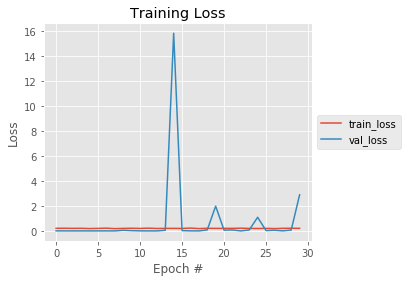

In [6]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))

In [7]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 75))

filepath = "/home/jupyter/Project/Inception/Inception_FT_Chkpt/Inception_FT_weights.01-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [8]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1961.3477327729693
len(df_preds): 8951
MAE: 0.2191205153360484


In [9]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45355.jpg,0.103847,0.001557,0.102290
8901,45356.jpg,0.100356,0.006145,0.094211
8902,45357.jpg,0.093201,0.008720,0.084481
8903,45358.jpg,0.089710,0.001557,0.088153
8904,45359.jpg,0.086219,0.006476,0.079743
8905,45360.jpg,0.080983,0.011160,0.069824
8906,45361.jpg,0.074002,0.001564,0.072438
8907,45362.jpg,0.074002,0.014712,0.059290
8908,45363.jpg,0.066846,0.012081,0.054765
8909,45364.jpg,0.063355,0.010789,0.052566
